In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt



In [2]:
def cholesky_sim(d0, Cd):
    L=np.linalg.cholesky(Cd)
    r = np.random.normal(0,1,d0.shape[0])
    d_star = d0 + np.dot(L,r)
    return d_star



def gaussian_rw(d0, Cd, r_in=[], is_chol=False, step = 0.1, method='gdm'):
    if is_chol:
        L = Cd
    else:
        L=np.linalg.cholesky(Cd)

    if len(r_in)==0:
        r = np.random.normal(0,1,d0.shape[0])
    else:
        if step>0:
            if method=='gdm':
                step_ang = step*np.pi/2
                r_new = np.random.normal(0,1,d0.shape[0])
                r = r_in*np.cos(step_ang) + r_new*np.sin(step_ang)
            else:
                n = Cd.shape[0]
                n_pert = int(np.ceil(step*n))
                r = r_in
                # select randomly n_pert of out n integer values
                i_pert = np.random.choice(n, n_pert, replace=False)
                r[i_pert]=np.random.normal(0,1,i_pert.shape)
        else:
            r = r_in

    d_star = d0 + np.dot(L,r)
    return d_star, r
    

def precal_distance(x,y):
    nx=len(x)
    ny=len(y)
    xx, yy = np.meshgrid(x,y)
    xx=xx.flatten()
    yy=yy.flatten()
    nd=xx.shape[0]
    d = np.sqrt((xx[:, np.newaxis] - xx[np.newaxis, :]) ** 2 + (yy[:, np.newaxis] - yy[np.newaxis, :]) ** 2)
    return d


def cov_gau(d,r,d_var):
    return d_var*np.exp(-3*d**2/r**2)

def cov_exp(d,r,d_var):
    return d_var*np.exp(-3*d/r)

def cov_nug(d,d_var):
    return d_var*(np.where(d == 0, 1.0, 0.0))
     
def cov_sph(d,r,d_var):

    C = 1-1.5*d/r + 0.5*(d/r)**3
    # set C=0 for d>r
    C = np.where(d > r, 0.0, C)
    C = d_var*C

    #np.where(d > r, 1.0, C)

    #return d_var*np.exp(-3*d**2/r**2)
    return C

def cov_cal(d,r,d_var, model='gaussian'):
    if model=='gaussian':
        return cov_gau(d,r,d_var)
    elif model=='exponential':
        return cov_exp(d,r,d_var)
    elif model=='spherical':
        return cov_sph(d,r,d_var)
    elif model=='nugget':
        return cov_nug(d,d_var)
    else:
        print('Model not found')
        return None

In [3]:
mat_file = '1D_traveltime_data.mat'

M = sp.io.loadmat(mat_file)

In [4]:
d_obs = M['d_obs'].flatten()
d_std = M['d_std'].flatten()
G = M['G']
z_data = M['z_data'].flatten()
dz = M['dz'][0][0]
m0 = M['v0'].flatten().astype(float)
s0 = 1/m0
nm=len(m0)
# z=0,10,20,,,,290
z = np.arange(0,dz*nm,dz)

d = np.zeros((nm,nm))
for i in range(nm):
    for j in range(nm):
        d[i,j] = np.abs(z[i]-z[j])


# setup covariance using a range of r=20, and a variance of 5.4772 10⁻5
r = 20
d_var = 5.4772e-5**2
cov_g = cov_cal(d,r,d_var,model='gaussian')
cov_n = cov_cal(d,r,0.01*d_var,model='nugget')
cov_e = cov_cal(d,r,d_var,model='exponential')

C = cov_g + cov_n
C = cov_e
L = np.linalg.cholesky(C)

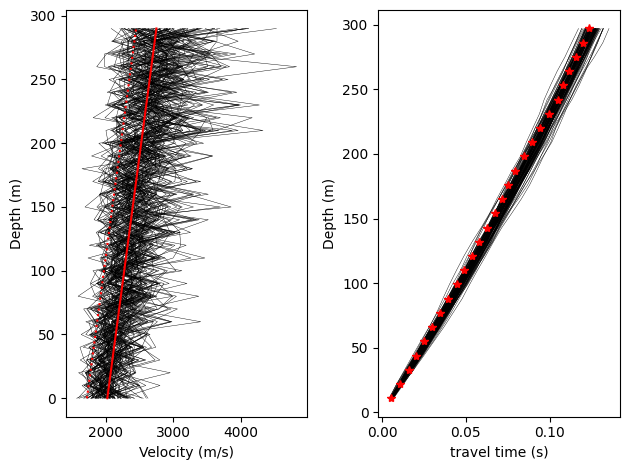

In [5]:
def forward_model(m, G):
    # compute d as a function of m
    s = 1/m
    d = np.dot(G, s)
    return d

def sample_prior(m_c = [], step=0.1, n_p=5):
    
    if len(m_c) == 0:
        r = 2000*(np.random.random(m0.shape)-.5)
        m_p = m0 + r
    else:
        # select a random sample of size n=5 from a seirs on number from 1 to 30
        i_pert = np.random.choice(nm, n_p, replace=False)

        r = step*(np.random.random(m_c.shape)-.5)
        r= step * np.random.randn(nm,1)
        r = r.flatten()
        m_p = m_c.copy()
        m_p[i_pert] = m_c[i_pert] + r[i_pert]
        m_diff = np.abs(m_p-m0)
        
        # find the number of modelparameters where dm is largner than 1000
        n_outside = len(np.where(m_diff>1000)[0])
        if n_outside>0:
            # print(n_outside)
            m_p = m_c
    return m_p

    
    
def likelihood(d, d_obs, d_std):
    useLog = True
    f = -0.5 * np.sum((d_obs - d) ** 2 / (d_std ** 2))
    #f = exp(f)
    return f

def plt_model(m_pro, color='k', lw=0.3):
    plt.subplot(1,2,1)
    plt.plot(m_pro,z,'-',linewidth=lw, color=color)
    plt.xlabel('Velocity (m/s)')
    plt.ylabel('Depth (m)')
    plt.grid()
    
    plt.subplot(1,2,2)
    d = forward_model(m_pro, G)
    plt.plot(d,z_data,'-',linewidth=lw, color=color)
    plt.xlabel('travel time (s)')
    plt.ylabel('Depth (m)')
    plt.tight_layout()

# define C



    
ns = 10000
m_prior_sample = np.zeros((ns,nm))

s_pro, r_pro = gaussian_rw(s0, L,is_chol=True)
m_pro = 1/s_pro
#m_pro =sample_prior()
#m_pro =m0
for i in range(ns):

    s_pro, r_pro = gaussian_rw(s0, L,is_chol=True, r_in = r_pro, step=0.1)
    m_pro = 1/s_pro

    #m_pro =sample_prior(m_pro, step = 400, n_p=3)
    m_prior_sample[i]=m_pro   

plt.figure(1)
for i in np.arange(0,ns,100):
    plt_model(m_prior_sample[i])
plt.subplot(1,2,1)
plt.plot(m0,z,'r-')
plt.plot(m0-300,z,'r:')
plt.subplot(1,2,2)
plt.plot(d_obs,z_data,'r*')
plt.show()

In [6]:
T=1
nite=1000000

m_post_sample = np.zeros((nite,nm))
logL_post = np.zeros((nite,1))

s_cur, r_cur = gaussian_rw(s0, L,is_chol=True)
m_cur = 1/s_cur
d_cur = forward_model(m_cur, G)
logL_cur = likelihood(d_cur, d_obs, d_std)

step = 1
n_p=10

iacc = 0
for i in range(nite):

    if i>10000:
        step = 0.1

    s_pro, r_pro = gaussian_rw(s0, L,is_chol=True, r_in = r_cur, step=0.1)
    m_pro = 1/s_pro

    #m_pro = sample_prior()
    #m_pro = sample_prior(m_cur,step=step, n_p=n_p)
    d_pro = forward_model(m_pro, G)
    logL_pro = likelihood(d_pro, d_obs, d_std)

    P_acc = np.exp(logL_pro - logL_cur)**(1/T)

    if P_acc > np.random.random():
        r_cur = r_pro.copy()
        m_cur = m_pro.copy()
        d_cur = d_pro.copy()
        logL_cur = logL_pro.copy()
        iacc = iacc + 1

    if i % 10000 == 0:
        print("i=%05s, AccRatio=%3.2f, logL_cur=%f" % (i,iacc/(i+1), logL_cur))

    m_post_sample[i] = m_cur
    logL_post[i] = logL_cur

/tmp/ipykernel_1355179/1675585049.py:29: RuntimeWarning: overflow encountered in exp
  P_acc = np.exp(logL_pro - logL_cur)**(1/T)


i=    0, AccRatio=1.00, logL_cur=-16660.473562
i=10000, AccRatio=0.01, logL_cur=-41.178049
i=20000, AccRatio=0.01, logL_cur=-20.918803
i=30000, AccRatio=0.00, logL_cur=-25.531525
i=40000, AccRatio=0.00, logL_cur=-20.445142
i=50000, AccRatio=0.00, logL_cur=-18.704993
i=60000, AccRatio=0.00, logL_cur=-19.312627
i=70000, AccRatio=0.00, logL_cur=-13.509710
i=80000, AccRatio=0.00, logL_cur=-21.120467
i=90000, AccRatio=0.00, logL_cur=-20.446555
i=100000, AccRatio=0.00, logL_cur=-15.238921
i=110000, AccRatio=0.00, logL_cur=-15.344773
i=120000, AccRatio=0.00, logL_cur=-16.949601
i=130000, AccRatio=0.00, logL_cur=-15.459367
i=140000, AccRatio=0.00, logL_cur=-13.657131
i=150000, AccRatio=0.00, logL_cur=-15.501329
i=160000, AccRatio=0.00, logL_cur=-19.166051
i=170000, AccRatio=0.00, logL_cur=-19.028956
i=180000, AccRatio=0.00, logL_cur=-13.806236
i=190000, AccRatio=0.00, logL_cur=-13.964556
i=200000, AccRatio=0.00, logL_cur=-9.960738
i=210000, AccRatio=0.00, logL_cur=-14.601154
i=220000, AccRatio

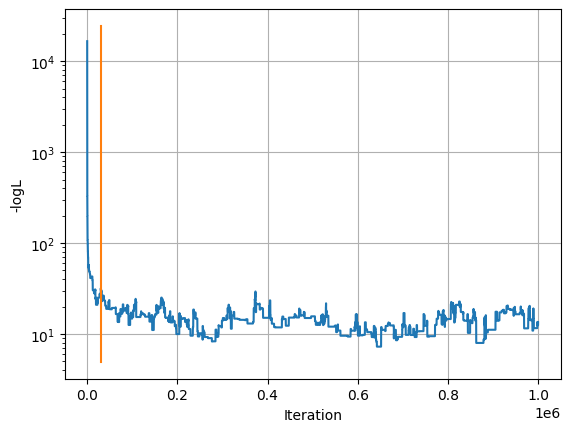

In [7]:
i_burnin = 30000

plt.figure()
plt.semilogy(-1*logL_post)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('-logL')
plt.plot([i_burnin,i_burnin],plt.ylim())
plt.show()

In [8]:
m_post_sample = m_post_sample[i_burnin:]
logL_post = logL_post[i_burnin:]

<function matplotlib.pyplot.show(close=None, block=None)>

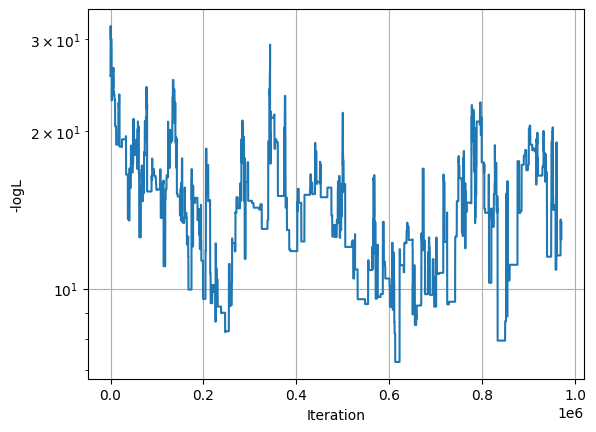

In [9]:
plt.figure()
plt.semilogy(-1*logL_post)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('-logL')
plt.show

In [10]:
plAutoCorr=False
if plAutoCorr:
    plt.subplot(3,1,1)
    plt.acorr(logL_post.flatten()-np.mean(logL_post),maxlags=1000)
    im=10
    plt.subplot(3,1,2)
    plt.acorr(m_post_sample[:,im]-np.mean(m_post_sample[:,im]),maxlags=1000)
    plt.title('m[%d]' % im)
    im=20
    plt.subplot(3,1,3)
    plt.acorr(m_post_sample[:,im]-np.mean(m_post_sample[:,im]),maxlags=1000)
    plt.title('m[%d]' % im)
    plt.tight_layout()

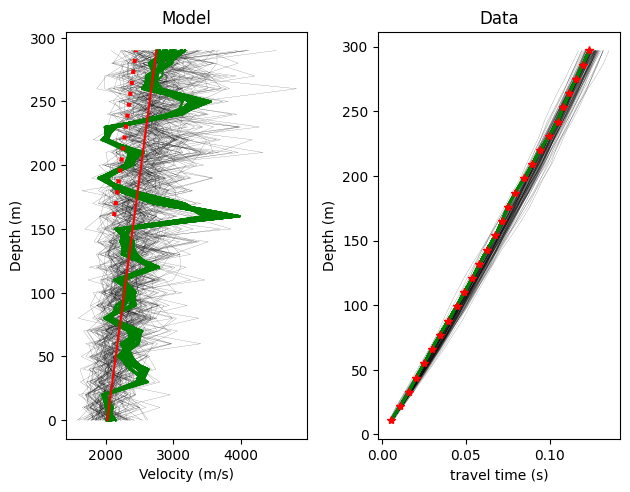

In [11]:

ns_prior = m_prior_sample.shape[0]
ns_post = m_post_sample.shape[0]
ns = np.min([ns_prior,ns_post])

# create an integer array from 0 to ns_prior in ns steps
i_prior = np.floor(np.linspace(0,ns_prior,ns)).astype(int)
# create an integer array from 0 to ns_post in ns steps
i_post = np.floor(np.linspace(0,ns_post,ns)).astype(int)
    
i_reservoir = np.where(z>150)[0]

plt.figure
for i in range(0,ns,int(np.ceil(ns/100))):
    plt_model(m_prior_sample[i_prior[i]], color='k', lw=0.1)
for i in range(0,ns,int(np.ceil(ns/100))):
    plt_model(m_post_sample[i_prior[i]], color='g', lw=1.5)
plt.subplot(1,2,1)
plt.plot(m0,z,'r-')
plt.plot(m0[i_reservoir]-300,z[i_reservoir],'r:',linewidth=3)
plt.title('Model')
plt.subplot(1,2,2)
plt.plot(d_obs,z_data,'r*')
plt.title('Data')
plt.show()

In [12]:
def nlay_res(m_real):
    i_reservoir = np.where(z>150)[0]
    n_res = len(np.where((m_real[i_reservoir]-m0[i_reservoir])<-300)[0])
    return n_res

m_real = m_post_sample[0]
n_res = nlay_res(m_real)

thickres_prior  = []
thickres_post = []
for i in range(0,ns,int(np.ceil(ns/1000))):
    n=nlay_res(m_prior_sample[i_prior[i]])
    thickres_prior.append(n*dz)
for i in range(0,ns,int(np.ceil(ns/1000))):
    n=nlay_res(m_post_sample[i_prior[i]])
    thickres_post.append(n*dz)
thickres_prior=np.array(thickres_prior)
thickres_post=np.array(thickres_post)

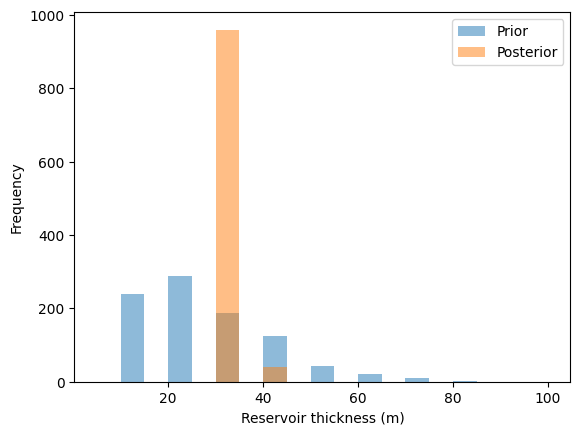

In [13]:
plt.figure()
plt.hist(thickres_prior, bins=np.arange(5,105,5), alpha=0.5, label='Prior')
plt.hist(thickres_post, bins=np.arange(5,105,5), alpha=0.5, label='Posterior')
plt.xlabel('Reservoir thickness (m)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [14]:
th=50
P_prior = len(np.where(thickres_prior>=th)[0])/len(thickres_prior)
print('P(Reservoir thickness >= %fm|prior) = %4.3f' % (th,P_prior)) 
P_post = len(np.where(thickres_post>=th)[0])/len(thickres_post)
print('P(Reservoir thickness >= %fm|post) = %4.3f' % (th,P_post)) 

P(Reservoir thickness >= 50.000000m|prior) = 0.078
P(Reservoir thickness >= 50.000000m|post) = 0.000
